In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [4]:
!git clone https://github.com/zeinashaarawy/DataOrbit

Cloning into 'DataOrbit'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 110 (delta 39), reused 59 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 30.65 MiB | 5.94 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [5]:
%cd DataOrbit

/content/DataOrbit


In [ ]:
!git checkout Zeina

Branch 'Zeina' set up to track remote branch 'Zeina' from 'origin'.
Switched to a new branch 'Zeina'


In [ ]:
!git pull origin main

From https://github.com/zeinashaarawy/DataOrbit
 * branch            main       -> FETCH_HEAD
Updating 0e7e2d0..eaa60b2
Fast-forward


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
beneficiaries = pd.read_csv('data/Train_Beneficiarydata.csv')
inpatient = pd.read_csv('data/Train_Inpatientdata.csv')
outpatient = pd.read_csv('data/Train_Outpatientdata.csv')
labels = pd.read_csv('data/Train_labels.csv')


In [8]:
print(beneficiaries.shape)
print(inpatient.shape)
print(outpatient.shape)
print(labels.shape)

beneficiaries.head()


(138556, 25)
(40474, 30)
(517737, 27)
(5410, 2)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [9]:
print("Missing values in Beneficiaries:")
print(beneficiaries.isnull().sum())

print("\nMissing values in Inpatient:")
print(inpatient.isnull().sum())

print("\nMissing values in Outpatient:")
print(outpatient.isnull().sum())

print("\nMissing values in Labels:")
print(labels.isnull().sum())


Missing values in Beneficiaries:
BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
O

In [10]:
def clean_column_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

In [11]:
beneficiaries = clean_column_names(beneficiaries)
inpatient = clean_column_names(inpatient)
outpatient = clean_column_names(outpatient)
labels = clean_column_names(labels)


Created is_deceased. When date of date is missing, patient is deceased. (1 is deceased and 0 is not)

In [12]:
beneficiaries['is_deceased'] = beneficiaries['dod'].notna().astype(int)

Dropped Columns with very high missing values

In [13]:
inpatient_drop_cols = [
    'operatingphysician', 'otherphysician',
    'clmdiagnosiscode_2','clmdiagnosiscode_3','clmdiagnosiscode_4','clmdiagnosiscode_5',
    'clmdiagnosiscode_6','clmdiagnosiscode_7','clmdiagnosiscode_8','clmdiagnosiscode_9','clmdiagnosiscode_10',
    'clmprocedurecode_1','clmprocedurecode_2','clmprocedurecode_3','clmprocedurecode_4','clmprocedurecode_5','clmprocedurecode_6'
]

In [14]:
inpatient_cleaned = inpatient.drop(columns=inpatient_drop_cols)

Filled in small missing values

In [15]:
inpatient_cleaned['attendingphysician'] = inpatient_cleaned['attendingphysician'].fillna('Unknown')
inpatient_cleaned['deductibleamtpaid'] = inpatient_cleaned['deductibleamtpaid'].fillna(0)

In [16]:
outpatient_drop_cols = [
    'operatingphysician', 'otherphysician',
    'clmdiagnosiscode_2','clmdiagnosiscode_3','clmdiagnosiscode_4','clmdiagnosiscode_5',
    'clmdiagnosiscode_6','clmdiagnosiscode_7','clmdiagnosiscode_8','clmdiagnosiscode_9','clmdiagnosiscode_10',
    'clmprocedurecode_1','clmprocedurecode_2','clmprocedurecode_3','clmprocedurecode_4','clmprocedurecode_5','clmprocedurecode_6',
    'clmadmitdiagnosiscode'
]


In [17]:
outpatient_cleaned = outpatient.drop(columns=outpatient_drop_cols)

In [18]:
outpatient_cleaned['attendingphysician'] = outpatient_cleaned['attendingphysician'].fillna('Unknown')

In [21]:
# Duplicate claims
print("Duplicate claims inpatient:", inpatient.duplicated(subset=['claimid']).sum())
print("Duplicate claims outpatient:", outpatient.duplicated(subset=['claimid']).sum())


Duplicate claims inpatient: 0
Duplicate claims outpatient: 0


Merge with beneficiary on beneid

In [22]:
inpatient_merged = inpatient_cleaned.merge(beneficiaries, on='beneid', how='left')
outpatient_merged = outpatient_cleaned.merge(beneficiaries, on='beneid', how='left')


Aggregate to combine all claims of provider into one row

In [23]:
provider_inpatient = inpatient_merged.groupby('provider').agg({
    'inscclaimamtreimbursed': ['sum','mean','max'],
    'deductibleamtpaid': ['sum','mean'],
    'beneid': 'nunique',
    'is_deceased': 'sum'  # number of deceased patients per provider
}).reset_index()

In [24]:
provider_outpatient = outpatient_merged.groupby('provider').agg({
    'inscclaimamtreimbursed': ['sum','mean','max'],
    'deductibleamtpaid': ['sum','mean'],
    'beneid': 'nunique',
    'is_deceased': 'sum'
}).reset_index()

Multiindex Columns


In [25]:
provider_inpatient.columns = [
    'provider', 'ip_claim_sum', 'ip_claim_mean', 'ip_claim_max',
    'ip_deductible_sum', 'ip_deductible_mean', 'ip_unique_patients', 'ip_deceased_patients'
]

provider_outpatient.columns = [
    'provider', 'op_claim_sum', 'op_claim_mean', 'op_claim_max',
    'op_deductible_sum', 'op_deductible_mean', 'op_unique_patients', 'op_deceased_patients'
]

In [26]:
print("Unique providers (inpatient):", inpatient_merged['provider'].nunique())
print("Unique providers (outpatient):", outpatient_merged['provider'].nunique())

print(provider_inpatient.head())
print(provider_outpatient.head())

Unique providers (inpatient): 2092
Unique providers (outpatient): 5012
   provider  ip_claim_sum  ip_claim_mean  ip_claim_max  ip_deductible_sum  \
0  PRV51001         97000   19400.000000         42000             5340.0   
1  PRV51003        573000    9241.935484         57000            66216.0   
2  PRV51007         19000    6333.333333         10000             3204.0   
3  PRV51008         25000   12500.000000         21000             2136.0   
4  PRV51011          5000    5000.000000          5000             1068.0   

   ip_deductible_mean  ip_unique_patients  ip_deceased_patients  
0              1068.0                   5                     0  
1              1068.0                  53                     1  
2              1068.0                   3                     0  
3              1068.0                   2                     0  
4              1068.0                   1                     0  
   provider  op_claim_sum  op_claim_mean  op_claim_max  op_deductible_

Merge to get single provider-level dataset

In [27]:
provider_full = provider_inpatient.merge(provider_outpatient, on='provider', how='outer').fillna(0)

Merge to add target values

In [29]:
provider_full = provider_full.merge(labels, on='provider', how='left')

In [30]:
provider_full.columns


Index(['provider', 'ip_claim_sum', 'ip_claim_mean', 'ip_claim_max',
       'ip_deductible_sum', 'ip_deductible_mean', 'ip_unique_patients',
       'ip_deceased_patients', 'op_claim_sum', 'op_claim_mean', 'op_claim_max',
       'op_deductible_sum', 'op_deductible_mean', 'op_unique_patients',
       'op_deceased_patients', 'potentialfraud'],
      dtype='object')

Make sure its categorical

In [31]:
provider_full['potentialfraud'] = provider_full['potentialfraud'].astype('category')


In [34]:
# compute beneficiaries with >=1 chronic condition
chronic_cols = [c for c in beneficiaries.columns if c.lower().startswith('chroniccond')]
beneficiaries['has_chronic'] = beneficiaries[chronic_cols].sum(axis=1) > 0

# provider <-> beneficiary relationship (from merged inpatient/outpatient mapping)
prov_bene_in = inpatient[['provider','beneid']].drop_duplicates()
prov_bene_out = outpatient[['provider','beneid']].drop_duplicates()
prov_bene = pd.concat([prov_bene_in, prov_bene_out]).drop_duplicates()

prov_bene = prov_bene.merge(beneficiaries[['beneid','has_chronic']], on='beneid', how='left')

chronic_per_provider = prov_bene.groupby('provider')['has_chronic'].sum().reset_index().rename(columns={'has_chronic':'chronic_patients'})

provider_full = provider_full.merge(chronic_per_provider, on='provider', how='left').fillna({'chronic_patients':0})

Add derived features

In [35]:
#Total claims (sum of inpatient + outpatient)
provider_full['total_claim_sum'] = provider_full['ip_claim_sum'] + provider_full['op_claim_sum']

#Average claim amount across all claims
provider_full['total_claim_mean'] = (provider_full['ip_claim_sum'] + provider_full['op_claim_sum']) / \
                                    (provider_full['ip_unique_patients'] + provider_full['op_unique_patients'] + 1e-6)

#Total deductible paid
provider_full['total_deductible_sum'] = provider_full['ip_deductible_sum'] + provider_full['op_deductible_sum']

#Average deductible per patient
provider_full['total_deductible_mean'] = (provider_full['ip_deductible_sum'] + provider_full['op_deductible_sum']) / \
                                         (provider_full['ip_unique_patients'] + provider_full['op_unique_patients'] + 1e-6)

#Total unique patients
provider_full['total_unique_patients'] = provider_full['ip_unique_patients'] + provider_full['op_unique_patients']

#Total deceased patients
provider_full['total_deceased_patients'] = provider_full['ip_deceased_patients'] + provider_full['op_deceased_patients']

#Ratio of deceased patients
provider_full['deceased_patient_ratio'] = provider_full['total_deceased_patients'] / \
                                          (provider_full['total_unique_patients'] + 1e-6)

#Claim per patient ratio
provider_full['claim_per_patient'] = provider_full['total_claim_sum'] / \
                                     (provider_full['total_unique_patients'] + 1e-6)

#Inpatient / Outpatient claim ratio
provider_full['ip_op_claim_ratio'] = provider_full['ip_claim_sum'] / (provider_full['op_claim_sum'] + 1e-6)

#Max claim / mean claim ratio (inpatient)
provider_full['ip_max_mean_ratio'] = provider_full['ip_claim_max'] / (provider_full['ip_claim_mean'] + 1e-6)

# 3. Chronic condition ratio (example using total patients with chronic conditions)
# Assuming you have aggregated chronic conditions from beneficiary data
# Example: provider_full['chronic_patients'] = number of patients with ≥1 chronic condition
provider_full['chronic_cond_ratio'] = provider_full.get('chronic_patients', 0) / \
                                     (provider_full['total_unique_patients'] + 1e-6)

#Average claim per deceased patient
provider_full['avg_claim_per_deceased'] = np.where(
    provider_full['total_deceased_patients'] > 0,
    provider_full['total_claim_sum'] / provider_full['total_deceased_patients'],
    0
)


In [36]:
print(provider_full.isna().sum())  # Make sure no NaNs remain
print(provider_full.dtypes)

provider                   0
ip_claim_sum               0
ip_claim_mean              0
ip_claim_max               0
ip_deductible_sum          0
ip_deductible_mean         0
ip_unique_patients         0
ip_deceased_patients       0
op_claim_sum               0
op_claim_mean              0
op_claim_max               0
op_deductible_sum          0
op_deductible_mean         0
op_unique_patients         0
op_deceased_patients       0
potentialfraud             0
chronic_patients_x         0
chronic_patients_y         0
total_claim_sum            0
total_claim_mean           0
total_deductible_sum       0
total_deductible_mean      0
total_unique_patients      0
total_deceased_patients    0
deceased_patient_ratio     0
claim_per_patient          0
ip_op_claim_ratio          0
ip_max_mean_ratio          0
chronic_cond_ratio         0
avg_claim_per_deceased     0
dtype: int64
provider                     object
ip_claim_sum                float64
ip_claim_mean               float64
ip_claim_

In [38]:
# Count of claims per provider
prov_claim_counts_ip = inpatient_merged.groupby('provider').size().reset_index(name='ip_claim_count')
prov_claim_counts_op = outpatient_merged.groupby('provider').size().reset_index(name='op_claim_count')

# Merge claim counts and then fill NaNs only in the newly added numerical columns
provider_full = provider_full.merge(prov_claim_counts_ip, on='provider', how='left')
provider_full = provider_full.merge(prov_claim_counts_op, on='provider', how='left')
provider_full['ip_claim_count'] = provider_full['ip_claim_count'].fillna(0)
provider_full['op_claim_count'] = provider_full['op_claim_count'].fillna(0)

provider_full['total_claim_count'] = provider_full['ip_claim_count'] + provider_full['op_claim_count']

# Percentiles for claim amounts (example: 90th percentile)
ip_90 = inpatient_merged.groupby('provider')['inscclaimamtreimbursed'].quantile(0.9).reset_index(name='ip_claim_90pct')
op_90 = outpatient_merged.groupby('provider')['inscclaimamtreimbursed'].quantile(0.9).reset_index(name='op_claim_90pct')

# Merge percentiles and then fill NaNs only in the newly added numerical columns
provider_full = provider_full.merge(ip_90, on='provider', how='left')
provider_full = provider_full.merge(op_90, on='provider', how='left')
provider_full['ip_claim_90pct'] = provider_full['ip_claim_90pct'].fillna(0)
provider_full['op_claim_90pct'] = provider_full['op_claim_90pct'].fillna(0)

In [39]:
print(provider_full.head())

   provider  ip_claim_sum  ip_claim_mean  ip_claim_max  ip_deductible_sum  \
0  PRV51001       97000.0   19400.000000       42000.0             5340.0   
1  PRV51003      573000.0    9241.935484       57000.0            66216.0   
2  PRV51004           0.0       0.000000           0.0                0.0   
3  PRV51005           0.0       0.000000           0.0                0.0   
4  PRV51007       19000.0    6333.333333       10000.0             3204.0   

   ip_deductible_mean  ip_unique_patients  ip_deceased_patients  op_claim_sum  \
0              1068.0                 5.0                   0.0        7640.0   
1              1068.0                53.0                   1.0       32670.0   
2                 0.0                 0.0                   0.0       52170.0   
3                 0.0                 0.0                   0.0      280910.0   
4              1068.0                 3.0                   0.0       14710.0   

   op_claim_mean  ...  claim_per_patient  ip_op_cl

In [41]:
provider_full.to_csv('data/provider_final_features.csv', index=False)

In [44]:
!git commit -m "added provider csv"

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git push -u origin Zeina

Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 325.58 KiB | 4.34 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/zeinashaarawy/DataOrbit.git
   0e7e2d0..bae7fa4  Zeina -> Zeina
Branch 'Zeina' set up to track remote branch 'Zeina' from 'origin'.


In [ ]:
from google.colab import files

files.download("notebooks/data_exploration.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from getpass import getpass
token = getpass("Enter your GitHub personal access token (hidden): ")


Enter your GitHub personal access token (hidden): ··········


In [ ]:
!
!git clone https://{token}@github.com/zeinashaarawy/DataOrbit.git

Cloning into 'DataOrbit'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 61 (delta 12), reused 36 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 27.87 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)


In [46]:
df = pd.read_csv("/content/DataOrbit/data/provider_final_features.csv")
df.head()


,provider,ip_claim_sum,ip_claim_mean,ip_claim_max,ip_deductible_sum,ip_deductible_mean,ip_unique_patients,ip_deceased_patients,op_claim_sum,op_claim_mean,...,claim_per_patient,ip_op_claim_ratio,ip_max_mean_ratio,chronic_cond_ratio,avg_claim_per_deceased,ip_claim_count,op_claim_count,total_claim_count,ip_claim_90pct,op_claim_90pct
0,PRV51001,97000.0,19400.000000,42000.0,5340.0,1068.0,5.0,0.0,7640.0,382.000000,...,4359.999818,12.696335,2.164948,0.0,0.0,5.0,20.0,25.0,39600.0,1000.0
1,PRV51003,573000.0,9241.935484,57000.0,66216.0,1068.0,53.0,1.0,32670.0,466.714286,...,5089.663823,17.539027,6.167539,0.0,605670.0,62.0,70.0,132.0,14000.0,1710.0
2,PRV51004,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,52170.0,350.134228,...,378.043476,0.000000,0.000000,0.0,52170.0,0.0,149.0,149.0,0.0,940.0
3,PRV51005,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,280910.0,241.124464,...,567.494948,0.000000,0.000000,0.0,70227.5,0.0,1165.0,1165.0,0.0,600.0
4,PRV51007,19000.0,6333.333333,10000.0,3204.0,1068.0,3.0,0.0,14710.0,213.188406,...,571.355923,1.291638,1.578947,0.0,33710.0,3.0,69.0,72.0,9200.0,500.0


In [47]:
print("Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)

df['potentialfraud'].value_counts()


Shape: (5410, 35)

Column Types:
provider                    object
ip_claim_sum               float64
ip_claim_mean              float64
ip_claim_max               float64
ip_deductible_sum          float64
ip_deductible_mean         float64
ip_unique_patients         float64
ip_deceased_patients       float64
op_claim_sum               float64
op_claim_mean              float64
op_claim_max               float64
op_deductible_sum          float64
op_deductible_mean         float64
op_unique_patients         float64
op_deceased_patients       float64
potentialfraud              object
chronic_patients_x           int64
chronic_patients_y           int64
total_claim_sum            float64
total_claim_mean           float64
total_deductible_sum       float64
total_deductible_mean      float64
total_unique_patients      float64
total_deceased_patients    float64
deceased_patient_ratio     float64
claim_per_patient          float64
ip_op_claim_ratio          float64
ip_max_mean_ratio     

,count
potentialfraud,
No,4904
Yes,506


/tmp/ipython-input-3046415345.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="potentialfraud", palette="viridis")


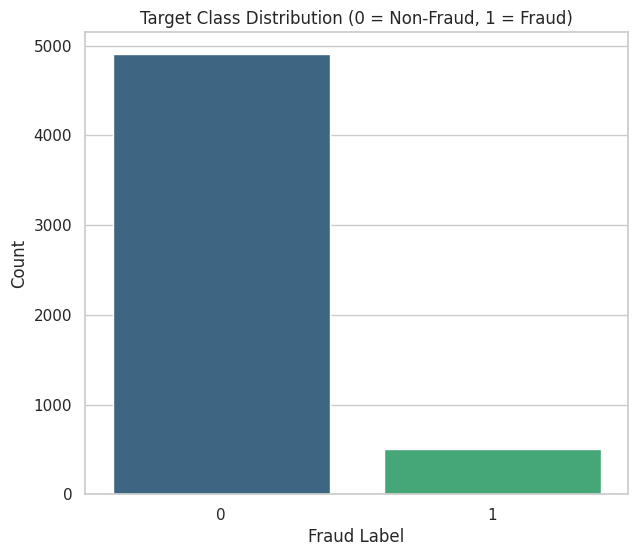

Fraud Rate: 9.35%


In [48]:
# Convert Yes/No to 1/0
df["potentialfraud"] = df["potentialfraud"].map({"Yes": 1, "No": 0}).astype(int)

# Plot
plt.figure(figsize=(7,6))
sns.countplot(data=df, x="potentialfraud", palette="viridis")
plt.title("Target Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Fraud Label")
plt.ylabel("Count")
plt.show()

# Fraud %
fraud_rate = df["potentialfraud"].mean() * 100
print(f"Fraud Rate: {fraud_rate:.2f}%")


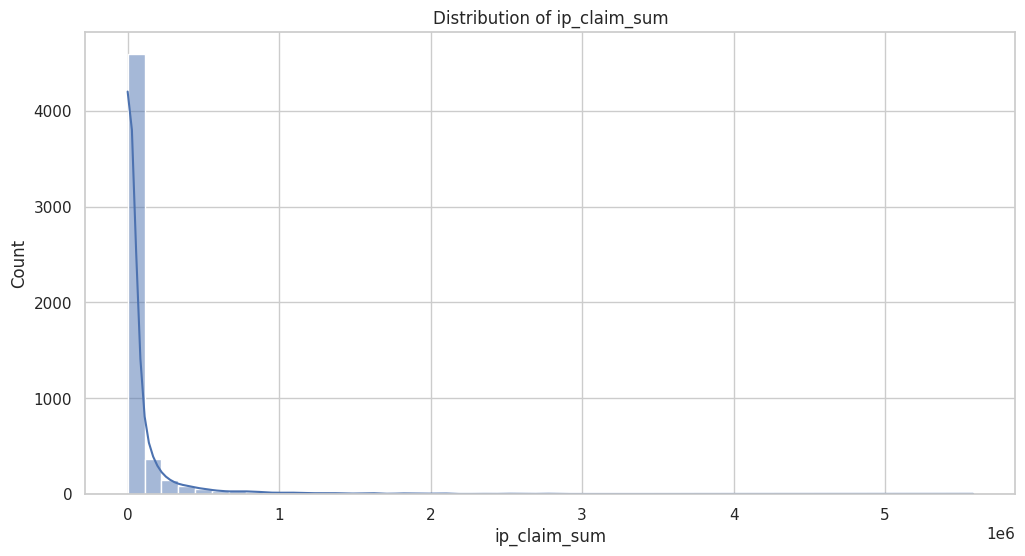

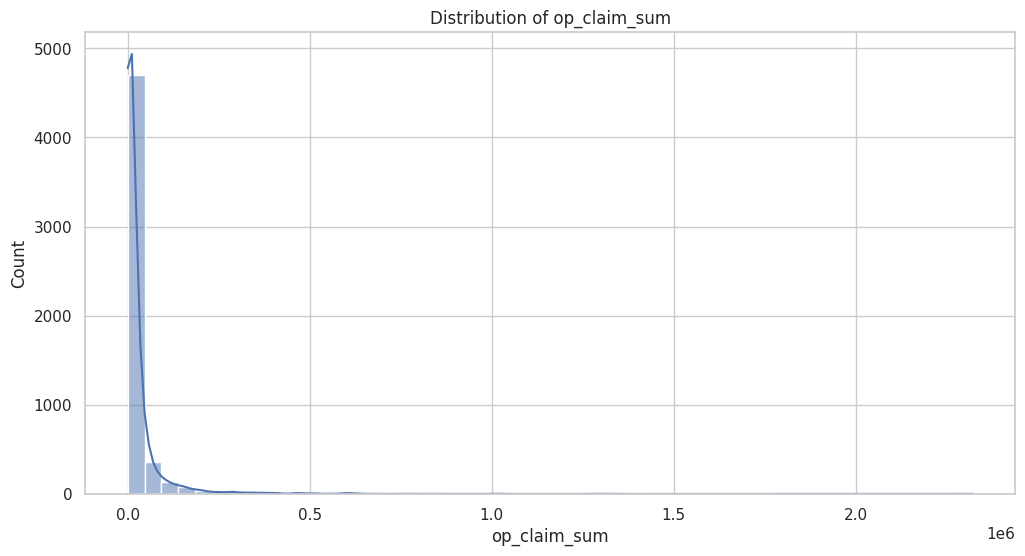

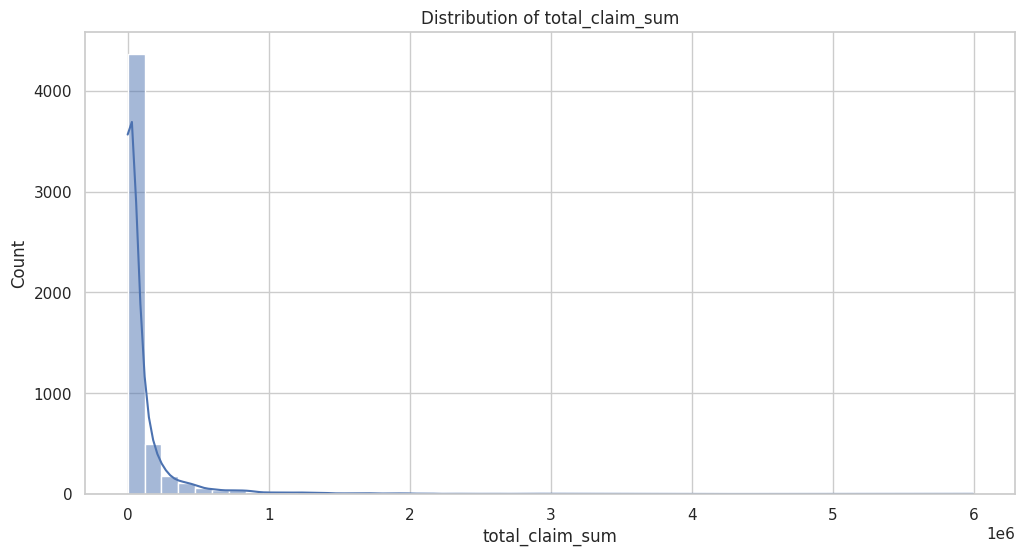

In [49]:
cols = ["ip_claim_sum", "op_claim_sum", "total_claim_sum"]

for c in cols:
    plt.figure()
    sns.histplot(df[c], bins=50, kde=True)
    plt.title(f"Distribution of {c}")
    plt.show()


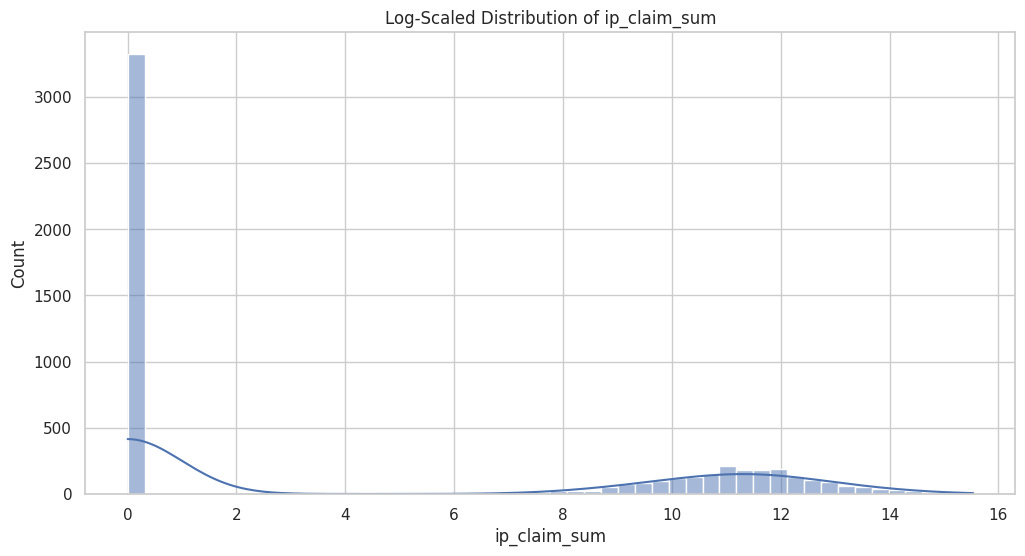

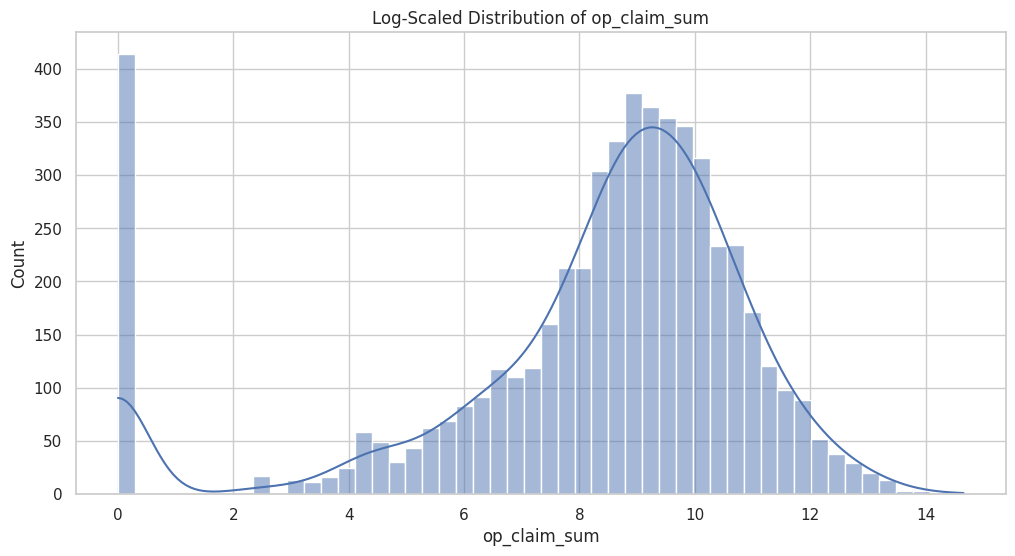

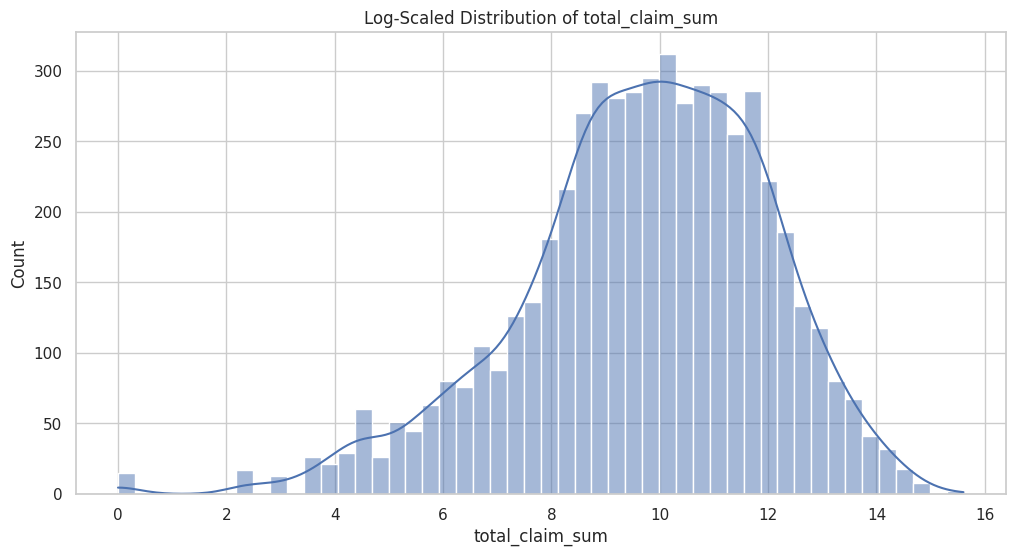

In [50]:
for c in cols:
    plt.figure()
    sns.histplot(np.log1p(df[c]), bins=50, kde=True)
    plt.title(f"Log-Scaled Distribution of {c}")
    plt.show()


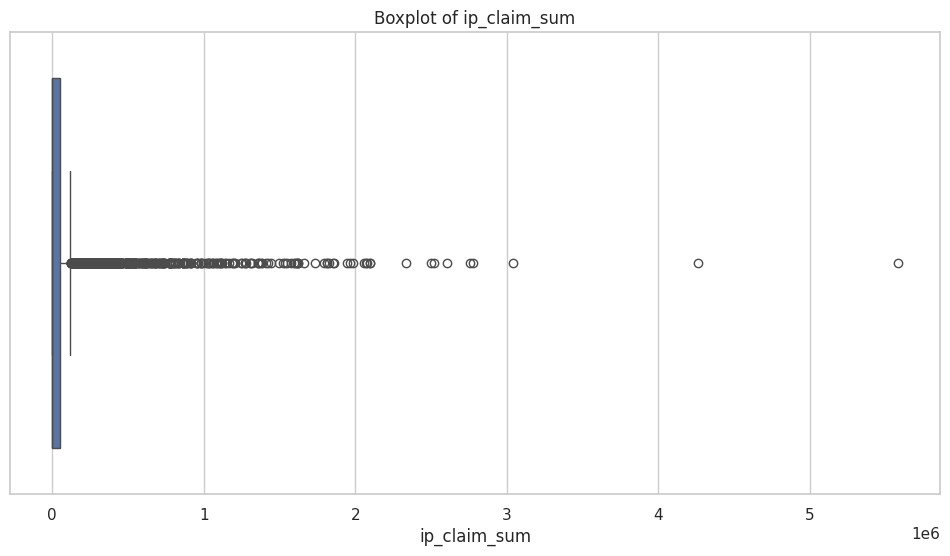

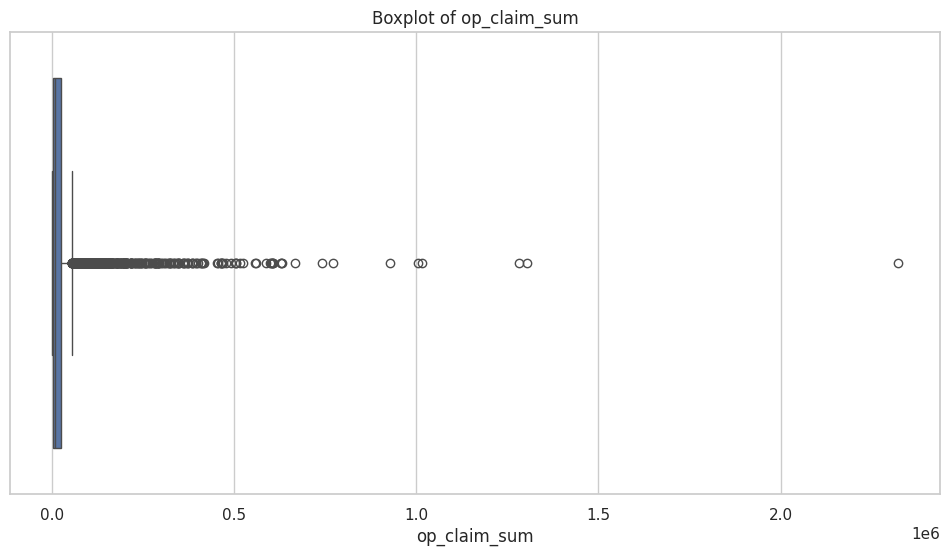

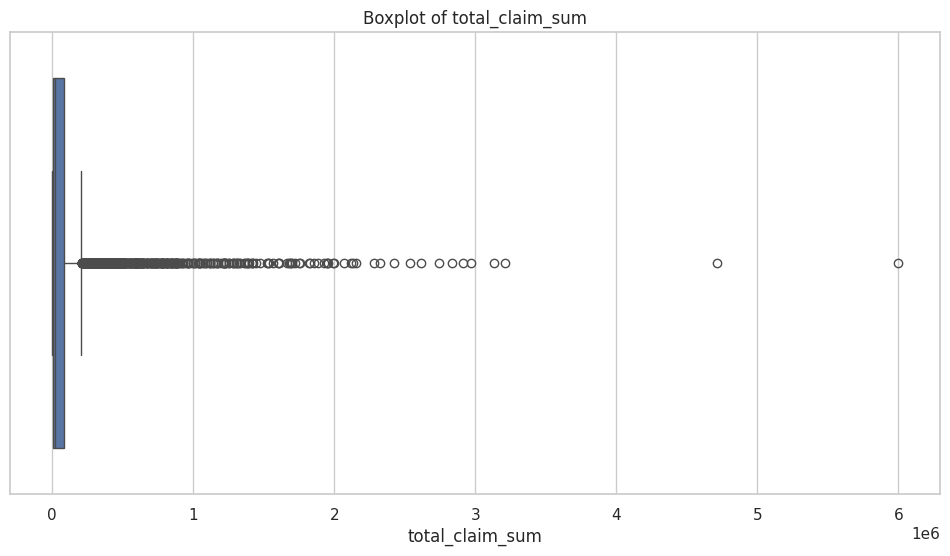

In [51]:
for c in cols:
    plt.figure()
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot of {c}")
    plt.show()


/tmp/ipython-input-966925295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="potentialfraud", y=c, palette="coolwarm")


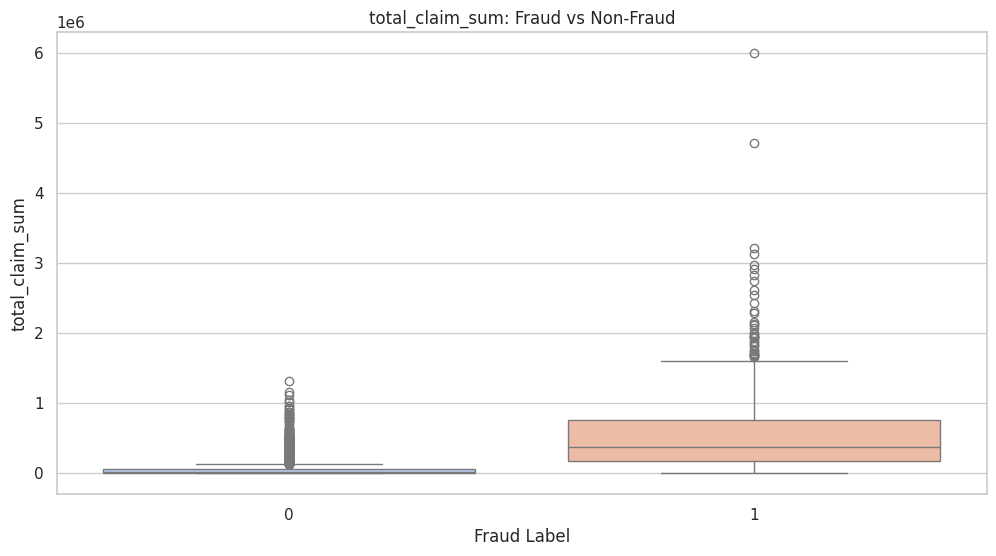

/tmp/ipython-input-966925295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="potentialfraud", y=c, palette="coolwarm")


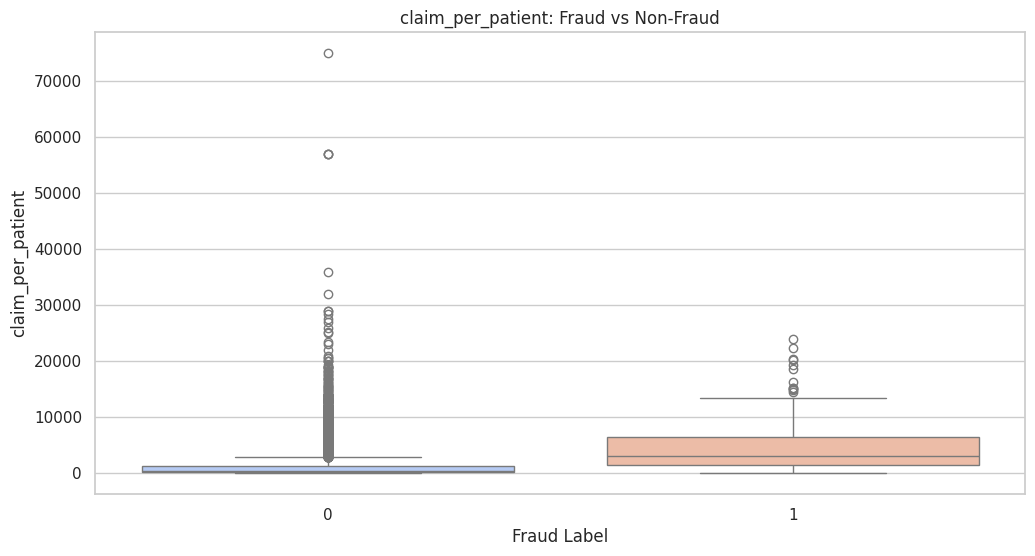

/tmp/ipython-input-966925295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="potentialfraud", y=c, palette="coolwarm")


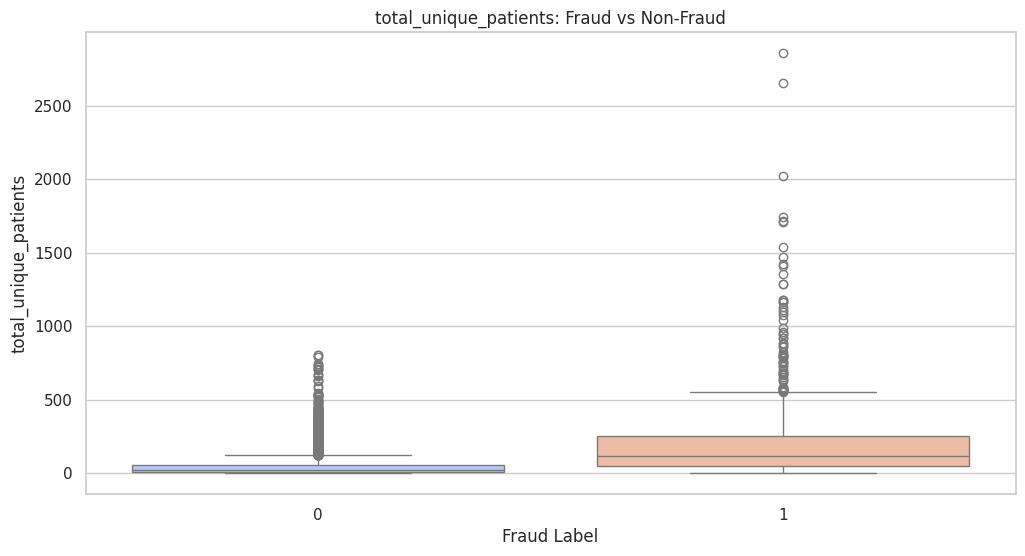

/tmp/ipython-input-966925295.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="potentialfraud", y=c, palette="coolwarm")


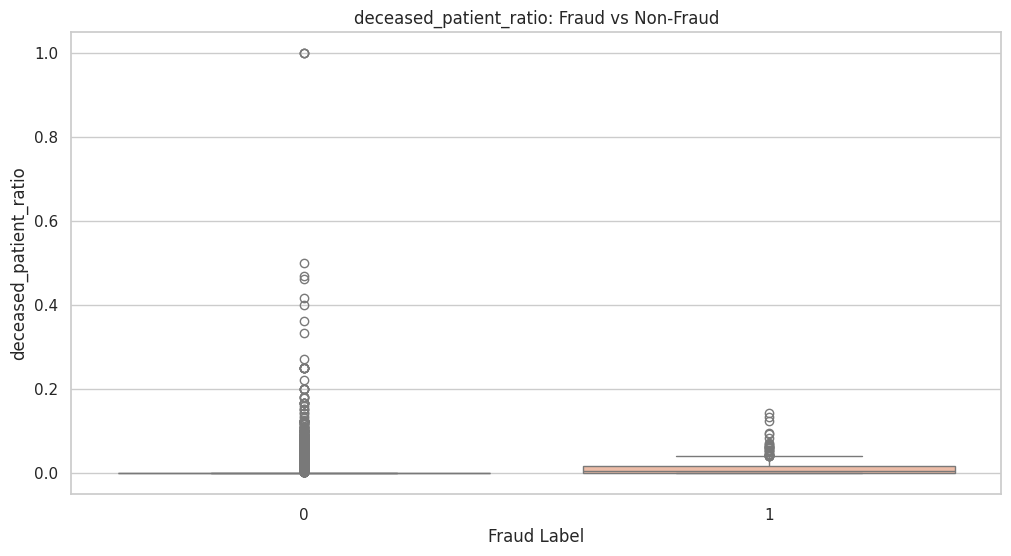

In [52]:
compare_cols = ["total_claim_sum", "claim_per_patient",
                "total_unique_patients", "deceased_patient_ratio"]

for c in compare_cols:
    plt.figure()
    sns.boxplot(data=df, x="potentialfraud", y=c, palette="coolwarm")
    plt.title(f"{c}: Fraud vs Non-Fraud")
    plt.xlabel("Fraud Label")
    plt.show()


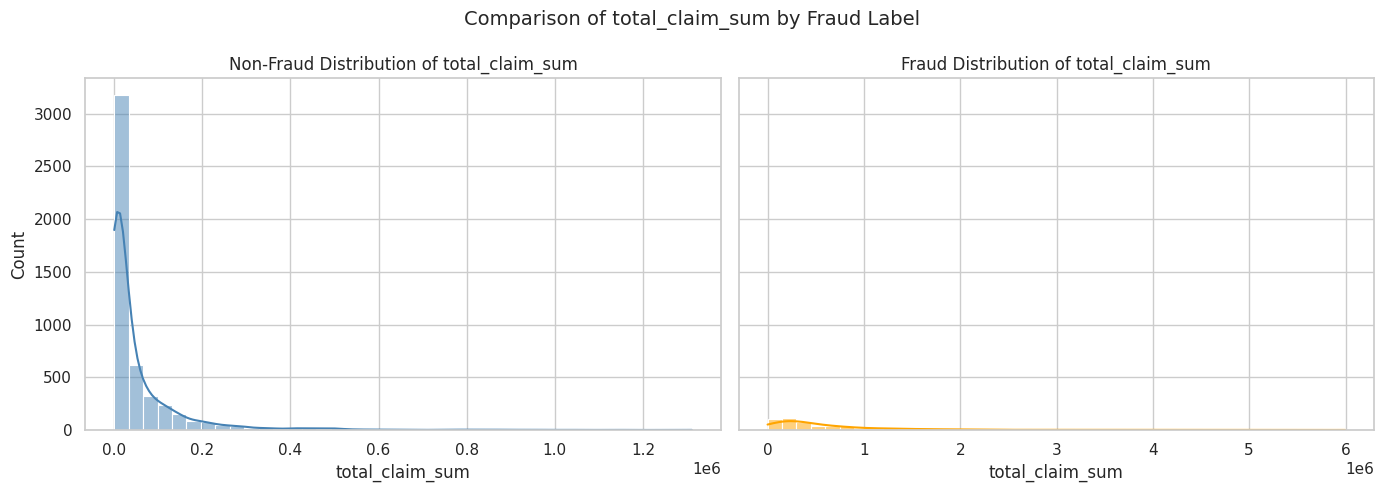

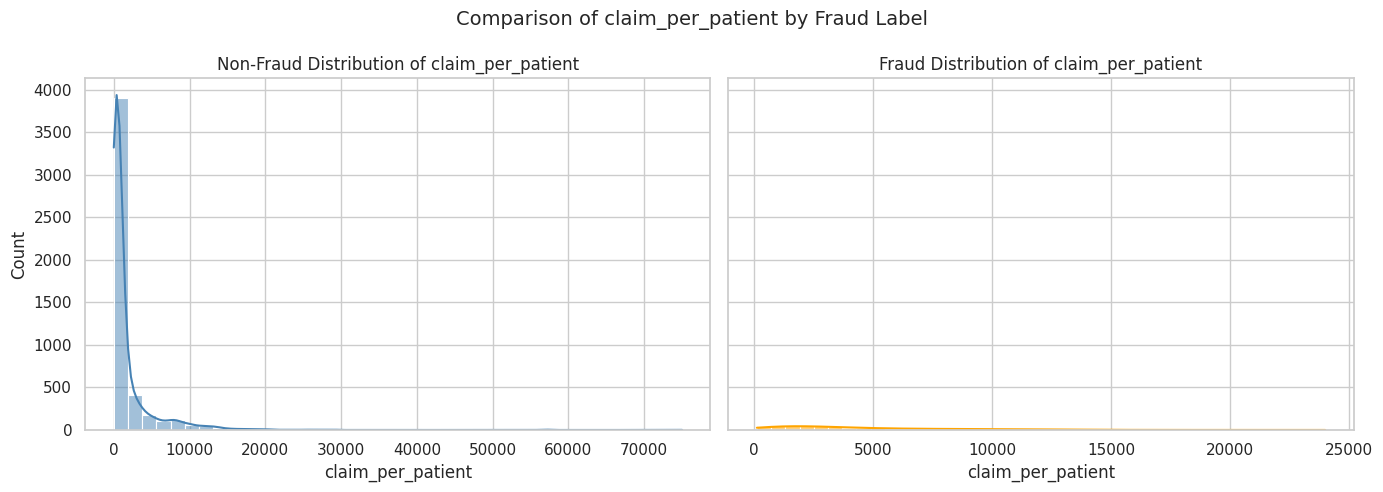

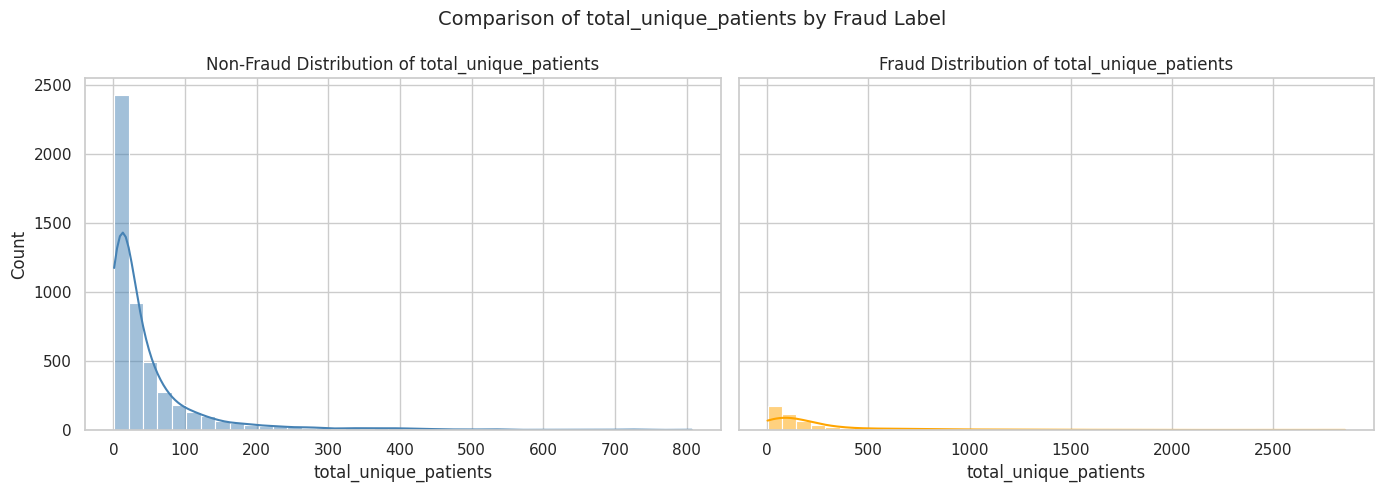

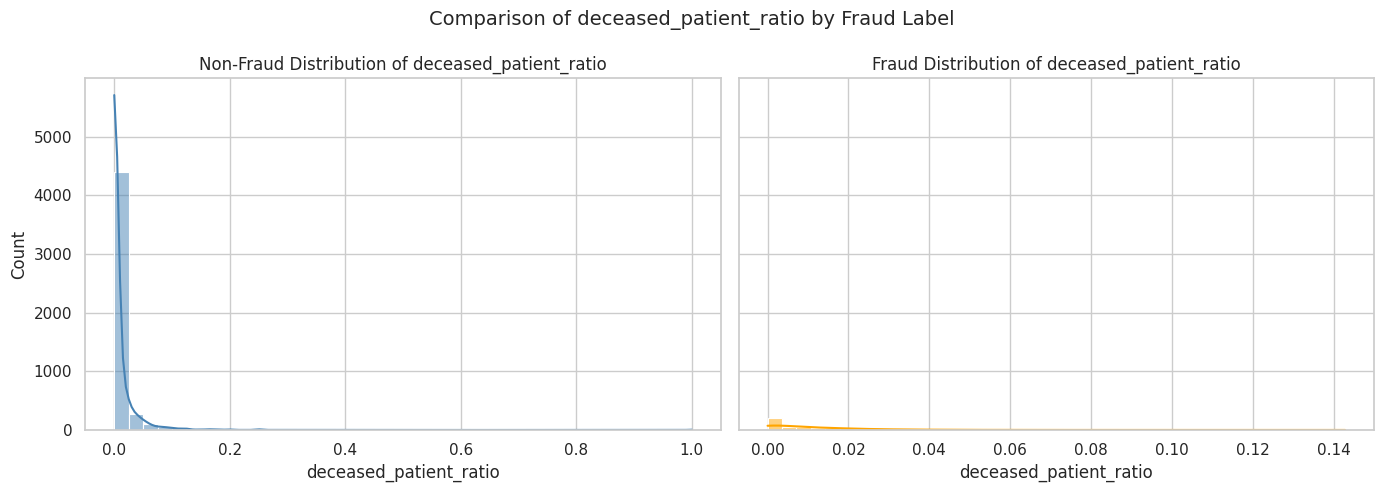

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features you want to compare
compare_cols = ["total_claim_sum", "claim_per_patient",
                "total_unique_patients", "deceased_patient_ratio"]

# Loop through each feature
for c in compare_cols:

    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

    # --- Non-Fraud (0) ---
    sns.histplot(df[df["potentialfraud"]==0][c],
                 bins=40, kde=True, color="steelblue", ax=axes[0])
    axes[0].set_title(f"Non-Fraud Distribution of {c}")
    axes[0].set_xlabel(c)

    # --- Fraud (1) ---
    sns.histplot(df[df["potentialfraud"]==1][c],
                 bins=40, kde=True, color="orange", ax=axes[1])
    axes[1].set_title(f"Fraud Distribution of {c}")
    axes[1].set_xlabel(c)

    plt.suptitle(f"Comparison of {c} by Fraud Label", fontsize=14)
    plt.tight_layout()
    plt.show()


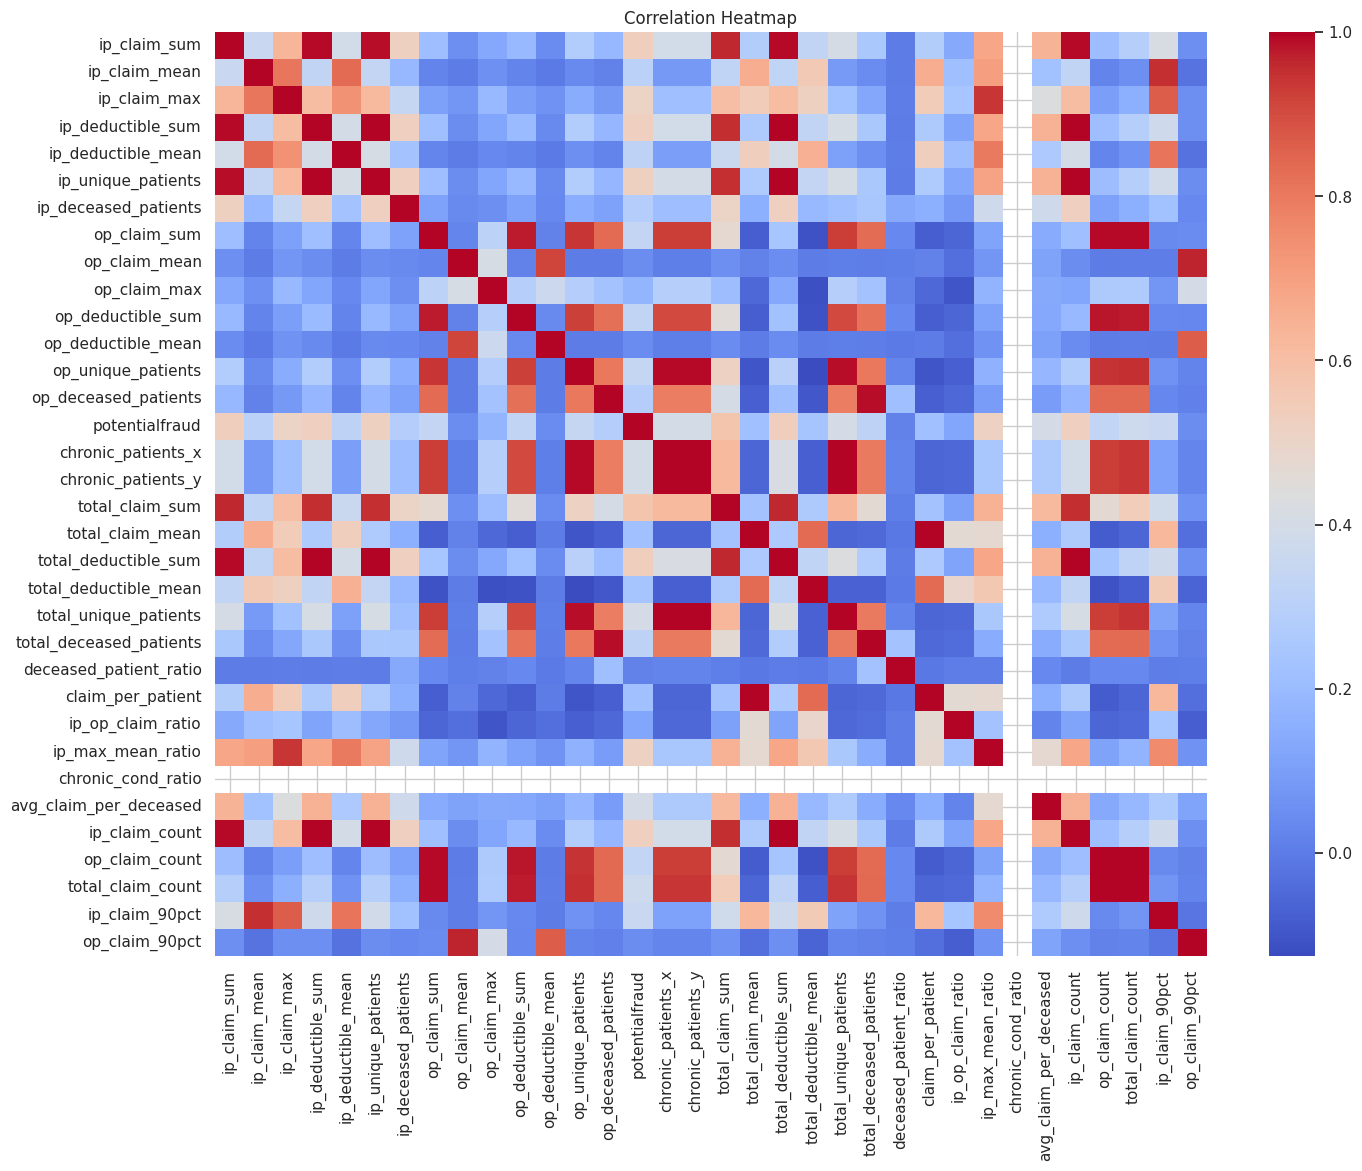

In [54]:
df_numeric = df.drop(columns=["provider"])
corr = df_numeric.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


/tmp/ipython-input-668585156.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_fraud.index.astype(str), y=state_fraud.values, palette="rocket")


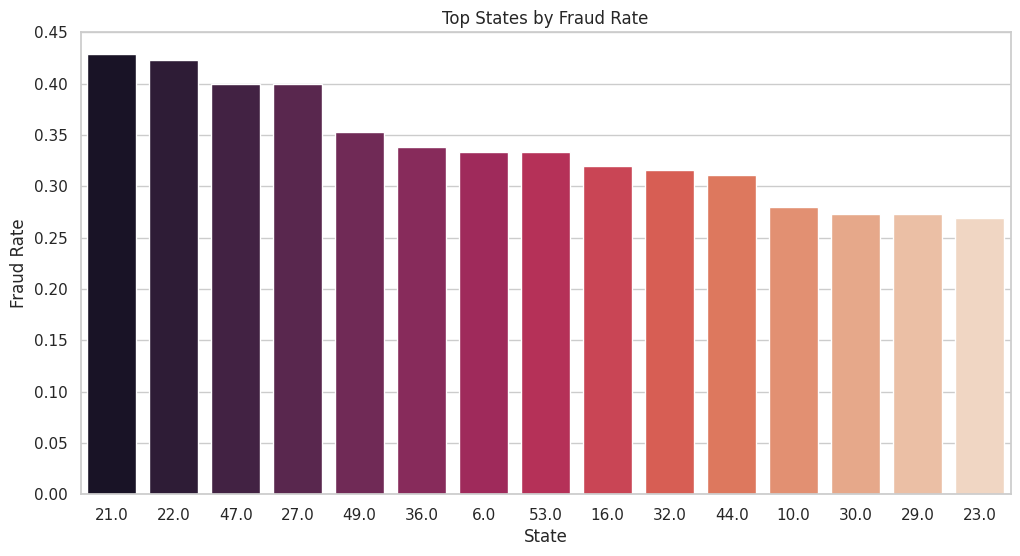

In [55]:
benef = pd.read_csv("/content/DataOrbit/data/Train_Beneficiarydata.csv")
benef = benef[["BeneID", "State"]]
benef.columns = ["beneid", "state"]

# merge with provider data
# recall: inpatient/outpatient were merged earlier by BeneID → Provider
# reload inpatient/outpatient for mapping

inpatient = pd.read_csv("/content/DataOrbit/data/Train_Inpatientdata.csv")
tmp = inpatient[["Provider","BeneID"]].drop_duplicates()
tmp.columns = ["provider","beneid"]

merged = tmp.merge(benef, on="beneid", how="left")
state_map = merged.groupby("provider")["state"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

df["state"] = df["provider"].map(state_map)

# plot
state_fraud = df.groupby("state")["potentialfraud"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=state_fraud.index.astype(str), y=state_fraud.values, palette="rocket")
plt.title("Top States by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.xlabel("State")
plt.show()


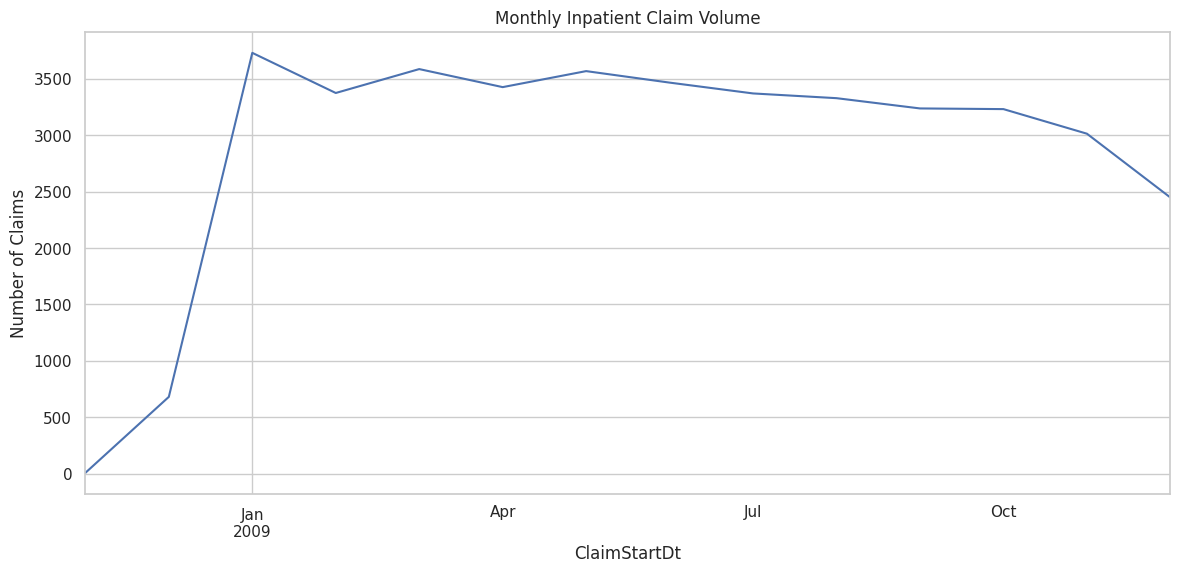

In [56]:
inpatient = pd.read_csv("/content/DataOrbit/data/Train_Inpatientdata.csv")
inpatient["ClaimStartDt"] = pd.to_datetime(inpatient["ClaimStartDt"])

monthly = inpatient.groupby(inpatient["ClaimStartDt"].dt.to_period("M")).size()

plt.figure(figsize=(14,6))
monthly.plot(kind="line")
plt.title("Monthly Inpatient Claim Volume")
plt.ylabel("Number of Claims")
plt.show()


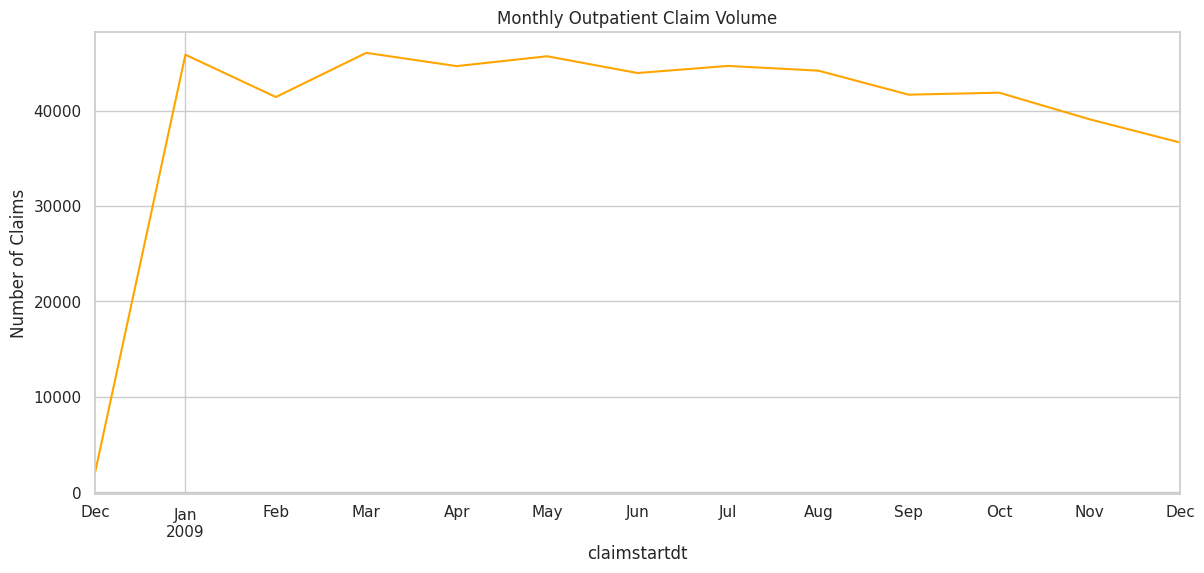

In [58]:
outpatient["claimstartdt"] = pd.to_datetime(outpatient["claimstartdt"])
monthly_op = outpatient.groupby(outpatient["claimstartdt"].dt.to_period("M")).size()

plt.figure(figsize=(14,6))
monthly_op.plot(kind="line", color='orange')
plt.title("Monthly Outpatient Claim Volume")
plt.ylabel("Number of Claims")
plt.show()

In [59]:
import scipy.stats as stats

cols = ['total_claim_sum','claim_per_patient','total_unique_patients','deceased_patient_ratio']
# Descriptive stats table
desc = df.groupby('potentialfraud')[cols].agg(['count','mean','median','std']).T
print(desc)

# Mann-Whitney U test for differences
for c in cols:
    stat, p = stats.mannwhitneyu(df[df['potentialfraud']==1][c],
                                 df[df['potentialfraud']==0][c], alternative='two-sided')
    print(f"{c} - Mann-Whitney p-value: {p:.4e}")


potentialfraud                             0              1
total_claim_sum        count     4904.000000     506.000000
                       mean     53193.723491  584350.039526
                       median   15055.000000  373450.000000
                       std     102342.349409  644668.507561
claim_per_patient      count     4904.000000     506.000000
                       mean      1694.733154    4482.395175
                       median     477.635551    3146.172143
                       std       3565.805203    4005.750086
total_unique_patients  count     4904.000000     506.000000
                       mean        49.385808     247.527668
                       median      22.000000     120.500000
                       std         82.375614     349.867285
deceased_patient_ratio count     4904.000000     506.000000
                       mean         0.009248       0.011514
                       median       0.000000       0.006319
                       std          0.03

In [60]:
print("Top Providers by Total Claim Amount:")
display(df.nlargest(10, "total_claim_sum")[["provider","total_claim_sum"]])

print("Top Claim per Patient:")
display(df.nlargest(10, "claim_per_patient")[["provider","claim_per_patient"]])

print("Top Deceased Patient Ratio:")
display(df.nlargest(10, "deceased_patient_ratio")[["provider","deceased_patient_ratio"]])


Top Providers by Total Claim Amount:


,provider,total_claim_sum
818,PRV52019,5996050.0
3557,PRV55462,4713830.0
4446,PRV56560,3212000.0
2705,PRV54367,3133880.0
3000,PRV54742,2969530.0
3358,PRV55209,2914700.0
2176,PRV53706,2831940.0
4334,PRV56416,2744870.0
3373,PRV55230,2612740.0
1071,PRV52340,2540130.0


Top Claim per Patient:


,provider,claim_per_patient
1631,PRV53033,74999.925000
1234,PRV52537,56999.943000
4841,PRV57080,56999.943000
5111,PRV57399,56999.943000
1456,PRV52804,35999.964000
1365,PRV52696,31999.989333
3529,PRV55431,28999.985500
3243,PRV55067,28999.971000
4713,PRV56903,28499.985750
5019,PRV57290,27499.986250


Top Deceased Patient Ratio:


,provider,deceased_patient_ratio
1577,PRV52954,0.999999
2013,PRV53511,0.999999
4536,PRV56677,0.999999
2504,PRV54120,0.500000
3747,PRV55691,0.470588
1394,PRV52731,0.461538
4682,PRV56864,0.416667
862,PRV52075,0.400000
2918,PRV54635,0.363636
1265,PRV52572,0.333333


In [ ]:
%cd DataOrbit


/content/DataOrbit


In [ ]:
!git fetch origin
!git checkout Judy


Branch 'Judy' set up to track remote branch 'Judy' from 'origin'.
Switched to a new branch 'Judy'


In [ ]:
!git branch


* Judy
  main


In [ ]:
!git pull origin main


From https://github.com/zeinashaarawy/DataOrbit
 * branch            main       -> FETCH_HEAD
Updating 82d7ce4..50a9503
Fast-forward
 README.md                        |      0
 data/Train_Beneficiarydata.csv   | 138557 ++++++++++
 data/Train_Inpatientdata.csv     |  40475 +++
 data/Train_Outpatientdata.csv    | 517738 ++++++++++++++++++++++++++++++++++++
 data/Train_labels.csv            |   5411 +
 data/provider_final_features.csv |   5411 +
 file.txt                         |      1 -
 notebooks/data_exploration.ipynb |   1676 +
 8 files changed, 709268 insertions(+), 1 deletion(-)
 create mode 100644 README.md
 create mode 100644 data/Train_Beneficiarydata.csv
 create mode 100644 data/Train_Inpatientdata.csv
 create mode 100644 data/Train_Outpatientdata.csv
 create mode 100644 data/Train_labels.csv
 create mode 100644 data/provider_final_features.csv
 delete mode 100644 file.txt
 create mode 100644 notebooks/data_exploration.ipynb


In [ ]:
%cd /content/DataOrbit


/content/DataOrbit


In [ ]:
!git branch


* Judy
  main


In [ ]:
!mv /content/EDA.ipynb notebooks/


mv: cannot stat '/content/EDA.ipynb': No such file or directory


In [ ]:
!find /content -name "*.ipynb"


/content/DataOrbit/notebooks/data_exploration.ipynb
